In [71]:
import matplotlib.pyplot as plt

import drjit as dr
import mitsuba as mi
from mitsuba.scalar_rgb import Transform4f as T

mi.set_variant('cuda_ad_rgb')

In [72]:
sensor_count = 7
sensors = []

for i in range(sensor_count):
    angle = 180.0 / sensor_count * i - 90.0
    sensor_rotation = mi.ScalarTransform4f.rotate([0, 1, 0], angle)
    sensor_to_world = mi.ScalarTransform4f.look_at(target=[0, 0, 0], origin=[0, 0, 4], up=[0, 1, 0])
    sensors.append(mi.load_dict({
        'type': 'perspective',
        'fov': 45,
        'to_world': sensor_rotation @ sensor_to_world,
        'film': {
            'type': 'hdrfilm',
            'width': 128, 'height': 128,
        }
    }))


In [73]:
scene_dict = {
    'type': 'scene',
    'integrator': {'type': 'prb_reparam'},
    'object': {
        'type': 'ply',
        'filename': 'MelaRosso.ply',
        'to_world': T.rotate([1, 0, 0], 260).scale(3),
        'bsdf': {'type': 'diffuse'},
    },
    'emitter': {
        'type': 'envmap',
        'filename': 'envmap.exr'
    }
}

scene_ref = mi.load_dict(scene_dict)

# Number of samples per pixel for reference images
ref_spp = 8

In [74]:
ref_images = [mi.render(scene_ref, sensor=sensors[i], spp=ref_spp) for i in range(sensor_count)]

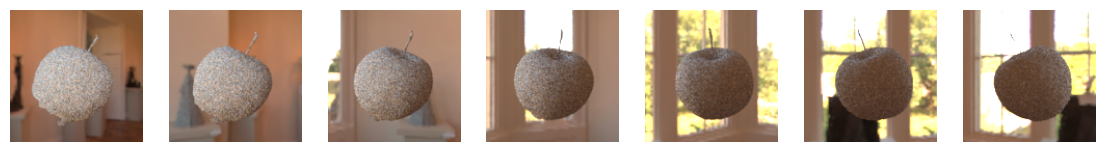

In [75]:
fig, axs = plt.subplots(1, sensor_count, figsize=(14, 4))
for i in range(sensor_count):
    axs[i].imshow(mi.util.convert_to_bitmap(ref_images[i]))
    axs[i].axis('off')

In [6]:
# Modify the scene dictionary
scene_dict['object'] = {
    'type': 'ply',
    'filename': 'Sphere.ply',
    'to_world': T.scale(0.5),
    'bsdf': {'type': 'diffuse'}
}

scene = mi.load_dict(scene_dict)

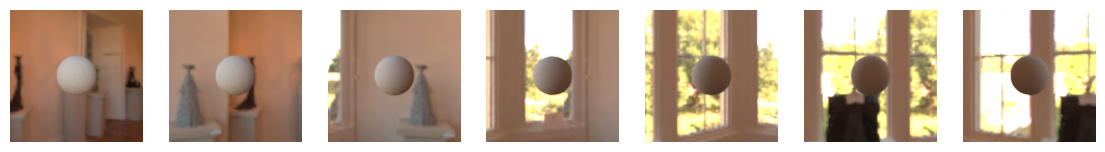

In [7]:
init_images = [mi.render(scene, sensor=sensors[i], spp=ref_spp) for i in range(sensor_count)]

fig, axs = plt.subplots(1, sensor_count, figsize=(14, 4))
for i in range(sensor_count):
    axs[i].imshow(mi.util.convert_to_bitmap(init_images[i]))
    axs[i].axis('off')

In [8]:
params = mi.traverse(scene)

key = 'object.vertex_positions'

opt = mi.ad.Adam(lr=0.01)
opt[key] = params[key]
params.update(opt);

iteration_count = 35
spp = 4
loss_hist = []

In [9]:
for it in range(iteration_count):
    total_loss = 0.0
    for sensor_idx in range(sensor_count):
        # Perform the differentiable light transport simulation
        img = mi.render(scene, params, sensor=sensors[sensor_idx], spp=spp, seed=it)

        # L2 loss function
        loss = dr.mean(dr.sqr(img - ref_images[sensor_idx]))

        # Backpropagate gradients
        dr.backward(loss)

        # Take a gradient step
        opt.step()

        # Clamp the optimized density values. Since we used the `scale` parameter
        # when instantiating the volume, we are in fact optimizing extinction
        # in a range from [1e-6 * scale, scale].
        opt[key] = dr.clamp(opt[key], -1.3, 1.3)

        # Propagate changes to the scene
        params.update(opt)

        total_loss += loss[0]
    print(f"Iteration {it:02d}: error={total_loss:6f}", end='\r')
    loss_hist.append(total_loss)

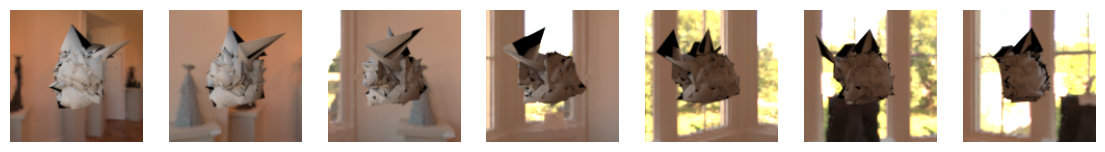

In [10]:
intermediate_images = [mi.render(scene, sensor=sensors[i], spp=ref_spp) for i in range(sensor_count)]

fig, axs = plt.subplots(1, sensor_count, figsize=(14, 4))
for i in range(sensor_count):
    axs[i].imshow(mi.util.convert_to_bitmap(intermediate_images[i]))
    axs[i].axis('off')

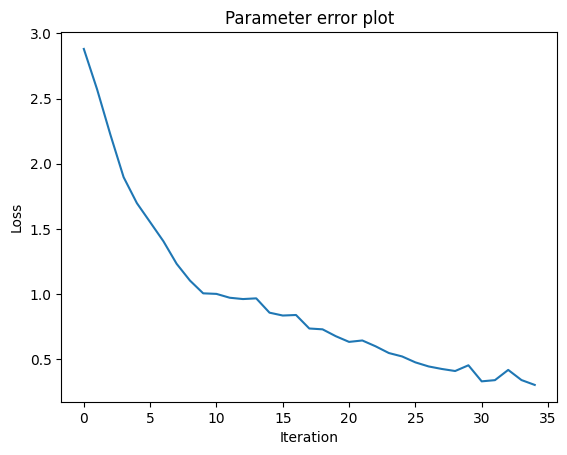

In [11]:
plt.plot(loss_hist)
plt.title('Parameter error plot')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()